In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple classification problem where the players are given different examples, and they have to classify their examples effectively while coming to a consensus on the best classifier on the whole dataset. Each individual computes the hinge loss for their classifier over their subset of the whole training set. The local $\xi_i$ accounts for the variation in the data that each player observes. The global $\xi$ is a normal random variable that shifts the decision boundary.

$$y = \text{sgn}(w^\top x + \xi)$$

# Generate Communication Network

In [2]:
n = 10  # Number of nodes
n_i = 2  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.path_graph(n)  # Generate line graph from the nodes in N

informed_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    informed_dict[node] = {'informed': N[node]}  
    
nx.set_node_attributes(G, informed_dict)  # set attributes for each node

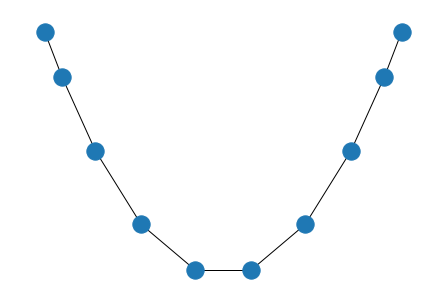

In [3]:
nx.draw_spectral(G)

# Generate Data

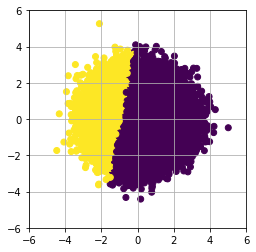

In [4]:
d = 2  # Dimension of the data
m = 100000  # Total training examples
m_i = math.ceil(m/n)  # Individual training examples

X = np.random.randn(m,d)  # Generate features normally distributed
a = np.random.randn(d)  # Generate true decision boundary
a = a/la.norm(a)  # Normalize vector that defines decision boundary
eta = 0.01  # Standard deviation of noise determining overlap at boundary
xi_t = 0.5*np.random.randn(1)  # \xi determines the offest of the decision boundary
y = np.sign(np.dot(X,a)+xi_t+(eta*np.random.randn(m)))  # Generate true labels for data points

# Plot data points with color to show class
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.grid()
plt.gca().set_aspect('equal')
plt.show()

# Loss and Gradient Oracles

In [5]:
def hinge_loss(x,y,w,xi,lambda_r):  # Hinge loss with offset
    try:
        m = len(y)
    except:
        m = 1
    y_hat = np.dot(w,x) + xi
    hinge = np.mean(np.maximum(1 - (y*y_hat), 0))
    reg = lambda_r*(0.5*la.norm(w)**2)
    return hinge + reg

def hinge_grad_batch(X,y,w,xi,lambda_r):  # Batch gradient calculation evaluated at xi (only update w)
    y_hat = np.dot(X,w) + xi
    mask = np.array([yh<=1 for yh in y_hat])
    return lambda_r*w - np.mean(X*(mask*y).reshape((-1,1)), axis=0)

def hinge_grad_sgd(x,y,w,xi,lambda_r):  # Single sample gradient calculation for SGD
    y_hat = np.dot(w,x) + xi
    if y*y_hat<=1:
        return lambda_r*w - x*y.reshape((-1,1))
    else:
        return lambda_r*w

# Centralized SGD

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


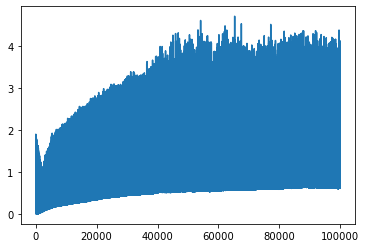

In [6]:
w = np.zeros(d)  # Initialize decision boundary
epochs = 1
step = 1e-3  # Step size
lambda_r = 1e-1  # Regularization parameter
loss = []
w_hist = []
idx = [i for i in range(m)]

# Run SGD with single samples for training
for i in trange(epochs):
    np.random.shuffle(idx)  # Shuffle training examples
    for j in idx:
        x = X[j]
        w_hist.append(w.reshape((-1,)))
        w = w - step*hinge_grad_batch(x,y[j],w,xi_t,lambda_r)
        w.reshape((2,))
        loss.append(hinge_loss(x,y[j],w,xi_t,lambda_r))
    
plt.figure()
plt.plot(loss)
plt.show()

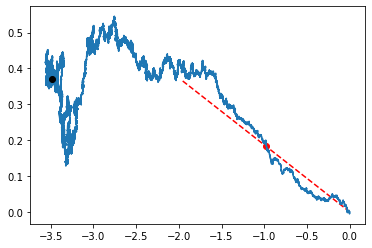

In [7]:
w_hist = np.array(w_hist)
plt.figure()
plt.scatter(a[0],a[1],c='r')
plt.plot([0,2*a[0]],[0,2*a[1]],'--',c='r')
plt.plot(w_hist[:,0],w_hist[:,1])
plt.scatter(w_hist[-1,0],w_hist[-1,1],c='k',zorder=10)
plt.show()

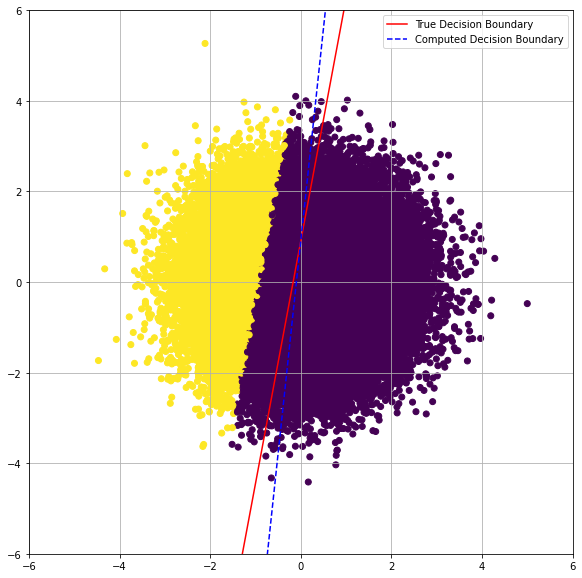

In [8]:
w = w.squeeze()
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot([-10,10], [10*a[0]/a[1]-xi_t,-10*a[0]/a[1]-xi_t], c='r', label='True Decision Boundary')
plt.plot([-10,10], [10*w[0]/w[1]-xi_t,-10*w[0]/w[1]-xi_t], '--', c='b', label='Computed Decision Boundary')
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.grid()
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

# Distributed SGD with synchronous information

In [9]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/1+np.max(np.diagonal(P)))*P  # Define doubly stochastic mixing matrix from Laplacian

W = np.zeros((n,d))  # Initialize decision boundaries

X_i = np.asarray([np.random.randn(m_i,d) for i in range(n)])  # generate data for each player
y_i = np.asarray([np.sign(np.dot(X_i[i],a)+xi_t+(eta*np.random.randn(m_i))) for i in range(n)])  # generate labels

epochs = 1
step = 1e-3  # step size
lambda_r = 1e-1  # regularization parameter
loss = []
W_hist = []
idx = [i for i in range(m_i)]

# run distributed SGD with consensus term
for k in trange(epochs):
    np.random.shuffle(idx)  # Shuffle training examples
    for j in idx:
        W_hist.append(W)
        for i in range(n):
            x_i = X_i[i,j]
            w_i = W[i,:]
            W[i,:] = np.dot(P,W)[i,:] - step*hinge_grad_batch(x_i,y_i[i,j],w_i,xi_t,lambda_r)

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


In [10]:
W

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]])